## Script source
The original scripts are here: https://mantas.info/code/simple_esn/ (MIT License). The scripts are modified for this guest lecture and hands-on.  
Here just copy and paste the announcement from the original script:
> A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data in "plain" scientific Python.  
> from https://mantas.info/code/simple_esn/  
> (c) 2012-2020 Mantas Lukoševičius  
> Distributed under MIT license https://opensource.org/licenses/MIT

## Echo state network
A seminal RC framework, echo state network (ESN), was proposed by Jaeger (2002) and Jaeger et al. (2016). This model uses an recurrent neural network (RNN) based reservoir consisting of discrete-time artificial neurons. When the feedback from the output to the reservoir is absent, the time evolution of the neuronal states in the reservoir is described as:
$$
\boldsymbol{X}_{t+1} = \boldsymbol{f}(\boldsymbol{W}_{in} \boldsymbol{u}_t + \boldsymbol{W} \boldsymbol{X}_t ),
$$
where t denotes discrete time, $\boldsymbol{X}_t$ is the state vector of the reservoir units, $\boldsymbol{u}_t$ is the input vector, $\boldsymbol{W}_{in}$ is the weight matrix for the input-reservoir connections, and $\boldsymbol{W}$ is the weight matrix for the recurrent connections in the reservoir. The function $ \boldsymbol{f}$ represents an element-wise activation function of the reservoir units, which is typically a sigmoid-type activation function.

## Implementation of echo state network (ESN)

Let's implement ESN with a few basic packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
# numpy.linalg is also an option for even fewer dependencies

Load demo data `MackeyGlass_t17.txt` in data folder.

In [6]:
# load the data
trainLen = 2000 # Training data length
testLen = 2000 # Testing data length
initLen = 100 # Initial burn-in
data = np.loadtxt('data/MackeyGlass_t17.txt')

Check how the data looks like.

Text(0.5, 1.0, 'A sample of data')

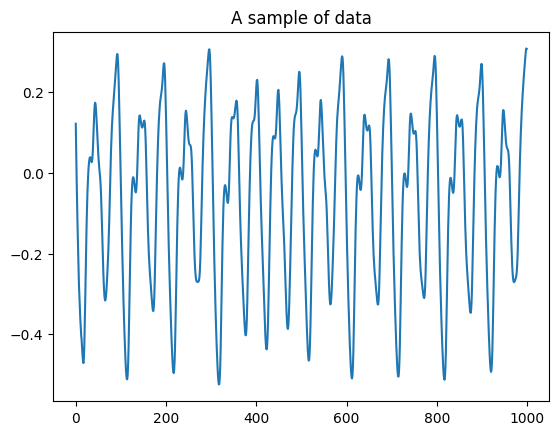

In [5]:
# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

Then let's generate the ESN reservoir.

In [7]:
# Input and output data size (= the number of variable)
inSize = outSize = 1

# Reservoir size (the number of nodes in the reservoir)
resSize = 1000
a = 0.3 # leaking rate (I did not explain this. At this point, you can just ignore this...)

In [9]:
# Set random seed
np.random.seed(42)

# Set input weight (how to transform input vector?)
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1

# Set reservoir weight  (how to transform reservoir state at each time step?)
W = np.random.rand(resSize,resSize) - 0.5 

# Normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

Computing spectral radius...
done.


In [18]:
# Check paramters
print("Win =", Win)
print("\nW =", W)
print("\nrhoW =", rhoW)
print("\nAdjusted leading eigenvalue = ", max(abs(linalg.eig(W)[0])))

Win = [[-0.12545988  0.45071431]
 [ 0.23199394  0.09865848]
 [-0.34398136 -0.34400548]
 ...
 [ 0.25137509  0.15695516]
 [ 0.45661462 -0.43104198]
 [-0.44294528 -0.21781293]]

W = [[-0.03236014 -0.03436003  0.05516898 ... -0.02583062 -0.02851161
   0.05043766]
 [ 0.0234529   0.04028905 -0.03388622 ... -0.01431698  0.0040659
  -0.04598598]
 [ 0.00977697  0.04147741  0.0353296  ... -0.02337878  0.04287792
   0.01321493]
 ...
 [-0.05237889 -0.04619835  0.04423342 ... -0.01112575 -0.00968637
   0.05831869]
 [ 0.01292204 -0.01837128 -0.06716951 ...  0.04988256 -0.06001321
  -0.03401321]
 [-0.0191577   0.06254913 -0.02867225 ... -0.05552273  0.02924733
   0.00515419]]

rhoW = 9.204778759016211

Adjusted leading eigenvalue =  1.2499999999999971


Prepare some objects that store results.

In [19]:
# Allocated memory for the design (collected states) matrix
X = np.zeros((1 + inSize + resSize, trainLen - initLen))

# Set the corresponding target matrix directly
Yt = data[None, initLen+1:trainLen+1] 

In [20]:
# Check parameters
print("X = ", X)
print("\nYt = ", Yt)

X =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Yt =  [[-0.09351762 -0.14571328 -0.19540772 ... -0.30151187 -0.33570312
  -0.36746866]]


In [21]:
# Run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]    

Train output using a simple linear regression (ridge regression).

In [22]:
# train the output by ridge regression
reg = 1e-8  # regularization coefficient

# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )

# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
    np.dot(X,Yt.T) ).T

In [23]:
# Run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

Compute summary statistics.

In [24]:
# Compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = 1.022948372547286e-06


## Visualize results
Visualize results using `plt` function.

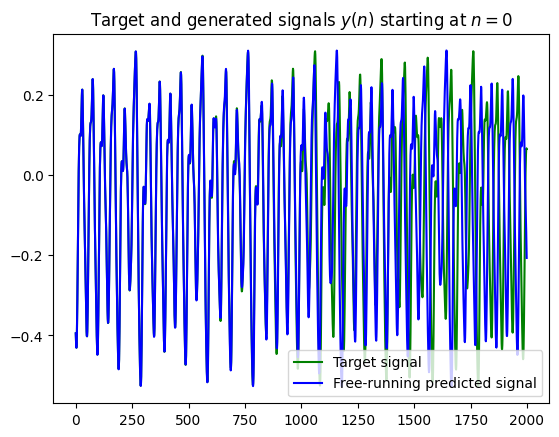

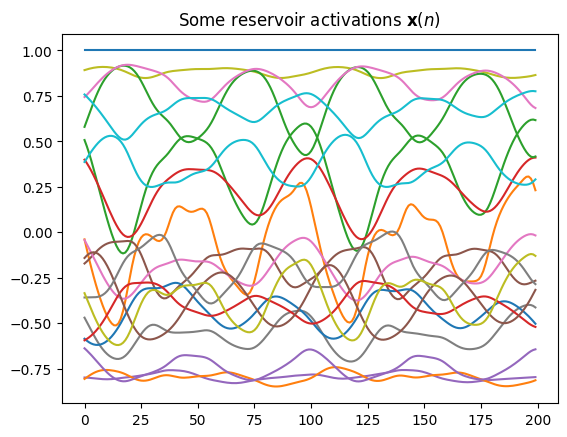

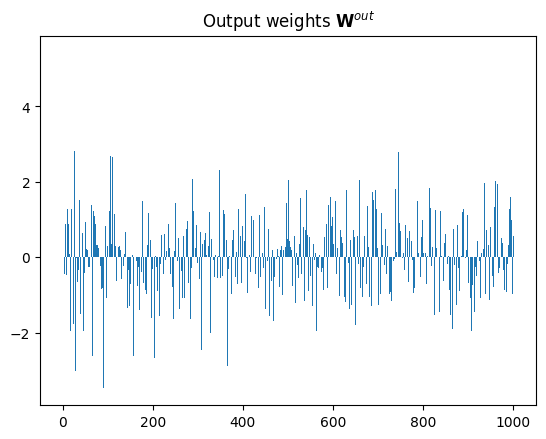

In [25]:
# Plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()


## References
- Jaeger H. 2002 Tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the" echo state network" approach. GMD-Forschungszentrum Informationstechnik Bonn.
- Jaeger H, Maass W, Principe J. 2007 Special issue on echo state networks and liquid state machines. Neural Netw. 20, 287–289. (doi:10.1016/j.neunet.2007.04.001)
-  https://mantas.info/code/simple_esn/